# MNIST

## Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
import numpy as np
import os

## Get the Data

In [5]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [6]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [7]:
X.shape

(70000, 784)

In [8]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [9]:
y.shape

(70000,)

Saving figure some_digit_plot


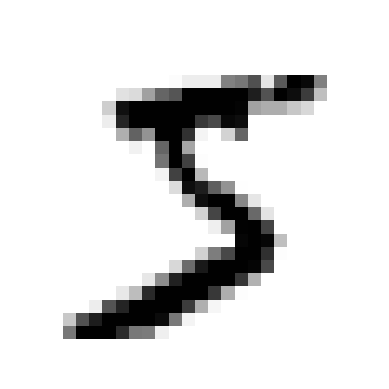

In [10]:
import matplotlib.pyplot as plt
from utils.save_image import save_fig

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

some_digit = X[0]

IMAGES_PATH = os.path.join("../images")
os.makedirs(IMAGES_PATH, exist_ok=True)
save_fig("some_digit_plot", IMAGES_PATH)

plot_digit(some_digit)
plt.show()

In [11]:
y[0]

'5'

Saving figure more_digits_plot


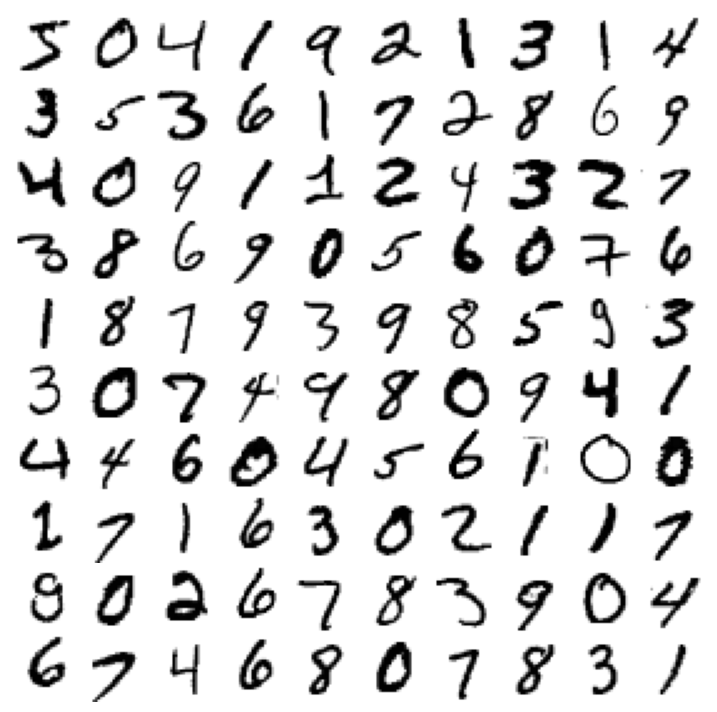

In [12]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", IMAGES_PATH,tight_layout=False)
plt.show()

In [13]:
y = y.astype(np.uint8)

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:],  y[:60000], y[60000:]

### Training a Binary Classifier

In [15]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [17]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [20]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(selfself, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [24]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

In [25]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

np.float64(0.8370879772350012)

In [26]:
recall_score(y_train_5, y_train_pred)

np.float64(0.6511713705958311)

In [27]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

np.float64(0.7325171197343847)

### Precision/Recall Trade-off

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [29]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [30]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


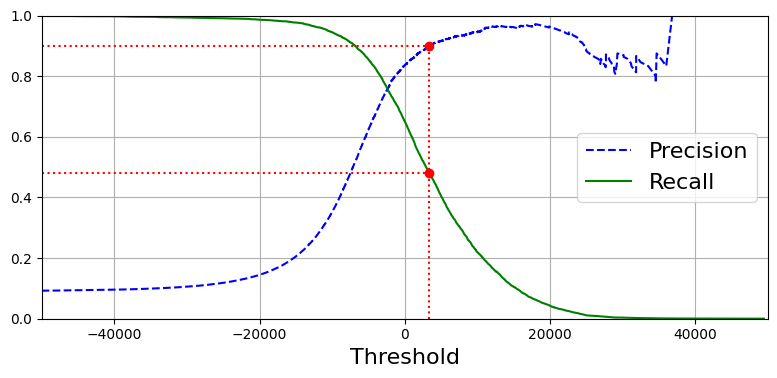

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend(loc='center right', fontsize=16)
    plt.xlabel('Threshold', fontsize=16)
    plt.grid(True)                             
    plt.axis([-50000, 50000, 0, 1])



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], 'r:')
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], 'r:')
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], 'r:')
plt.plot([threshold_90_precision], [0.9], 'ro')
plt.plot([threshold_90_precision], [recall_90_precision], 'ro')
save_fig('precision_recall_vs_threshold_plot', IMAGES_PATH)
plt.show()

Saving figure precision_vs_recall_plot


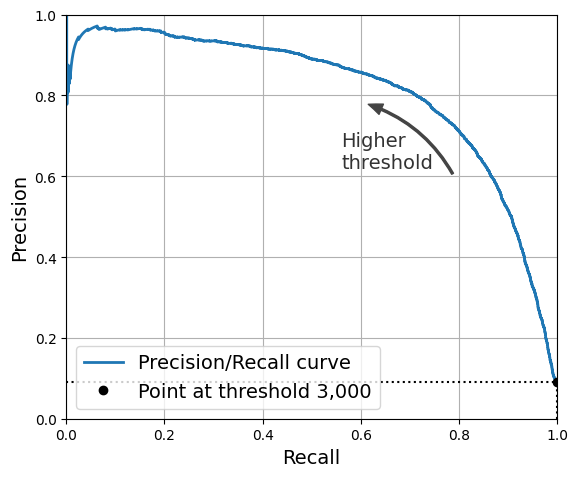

In [34]:
import matplotlib.patches as patches

plt.figure(figsize=(6, 5))

plt.plot(recalls, precisions, linewidth=2, label='Precision/Recall curve')

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], 'k:')
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], 'k:')
plt.plot([recalls[idx]], [precisions[idx]], 'ko',
         label='Point at threshold 3,000')
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle='arc3,rad=.2',
    arrowstyle='Simple, tail_width=1.5, head_width=8, head_length=10',
    color='#444444'))
plt.text(0.56, 0.62, 'Higher\nthreshold', color='#333333')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc='lower left')
save_fig('precision_vs_recall_plot', IMAGES_PATH)

plt.show()

In [35]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

np.float64(3370.0194991439557)

In [36]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [37]:
precision_score(y_train_5, y_train_pred_90)

np.float64(0.9000345901072293)

In [38]:
recall_score(y_train_5, y_train_pred_90)

np.float64(0.4799852425751706)

### The ROC Curve

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


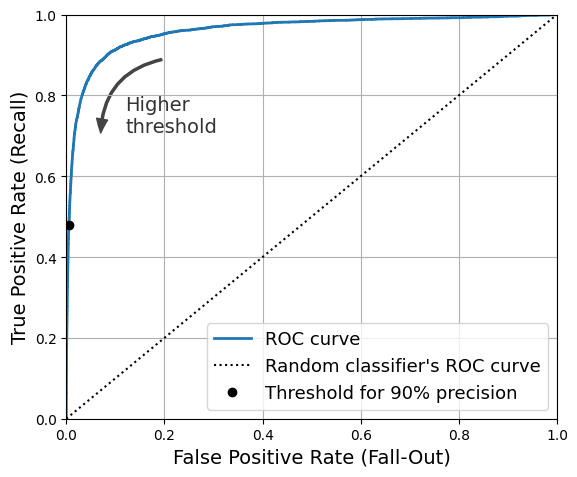

In [40]:
idx_for_threshold_at_90 = (thresholds <= threshold_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], 'ko', label='Threshold for 90% precision')

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle='arc3,rad=.4',
    arrowstyle='Simple, tail_width=1.5, head_width=8, head_length=10',
    color='#444444'))
plt.text(0.12, 0.71, 'Higher\nthreshold', color='#333333')
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc='lower right', fontsize=13)
save_fig('roc_curve_plot', IMAGES_PATH)

plt.show()

In [41]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [42]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [43]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method='predict_proba')

In [44]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Saving figure roc_curve_comparison_plot


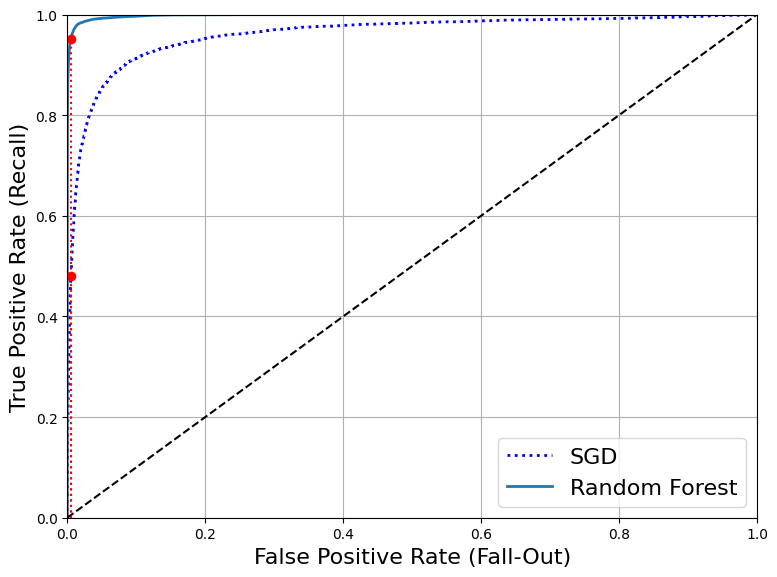

In [45]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plt.plot(fpr_forest, tpr_forest, linewidth=2, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.grid(True)     
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot", IMAGES_PATH)
plt.show()

In [46]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [47]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

np.float64(0.9905083315756169)

In [48]:
recall_score(y_train_5, y_train_pred_forest)

np.float64(0.8662608374838591)

## Multiclass Classification

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

In [ ]:
np.argmax(some_digit_scores)

In [ ]:
svm_clf.classes_

In [ ]:
svm_clf.classes_[5]

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

In [ ]:
sgd_clf.decision_function([some_digit])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3,
                scoring='accuracy')

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3,
                scoring='accuracy')

## Error Analysis